In [1]:
import os
import sys
sys.path.append('/home/test/test/liweihao/ember-optimize')
import ember
import numpy as np
import pandas as pd
import altair as alt
import lightgbm as lgb
import matplotlib.pylab as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
_ = alt.renderers.enable('notebook')

In [7]:
data_dir = "/home/test/test/liweihao/resultOfEmber/data_train_0.1_raw_parameter" # change this to where you unzipped the download

y_train_pred: [3.57428391e-11 1.29046444e-03 9.99999999e-01 3.81332034e-08
 9.99999998e-01]
y_test_pred: [9.99999973e-01 9.99999998e-01 1.34262907e-07 9.99997858e-01
 9.99999998e-01]
y_combined: [3.57428391e-11 1.29046444e-03 9.99999999e-01 3.81332034e-08
 9.99999998e-01 9.99999973e-01 9.99999998e-01 1.34262907e-07
 9.99997858e-01 9.99999998e-01]


In [3]:
# ember.create_vectorized_features(data_dir)
# _ = ember.create_metadata(data_dir)

In [4]:
emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir)

In [5]:
# 标准化数据
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# 初始化SVM分类器
svm_clf = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', random_state=42)

# 训练模型
svm_clf.fit(X_train, y_train)

SVC(random_state=42)

In [21]:
print(f"X_train length = {len(X_train)}")

# 检查 NaN 值
nan_rows = np.isnan(X_test).any(axis=1)
print(len(nan_rows))

# 检查无穷大值
inf_rows = np.isinf(X_test).any(axis=1)
print(len(inf_rows))

# 检查超过合理范围的值
# float64 的有效范围是 -1.7976931348623157e+308 到 1.7976931348623157e+308
# 自定义一个合理范围来检查
large_value_threshold = 1e+300
large_value_rows = (np.abs(X_test) > large_value_threshold).any(axis=1)
print(len(large_value_rows))

# 合并所有异常的行
abnormal_rows = nan_rows | inf_rows | large_value_rows

print(f"Number of rows with NaN values: {nan_rows.sum()}")
print(f"Number of rows with infinite values: {inf_rows.sum()}")
print(f"Number of rows with extremely large values: {large_value_rows.sum()}")
print(f"Total number of abnormal rows: {abnormal_rows.sum()}")

# 输出异常数值具体的行
abnormal_rows_indices = np.where(abnormal_rows)[0]
print("Indices of rows with abnormal values:")
print(abnormal_rows_indices)

# 查看异常数值的具体内容
print("Rows with abnormal values:")
print(X_test[abnormal_rows])

X_train length = 24927
224344
224344
224344
Number of rows with NaN values: 1
Number of rows with infinite values: 0
Number of rows with extremely large values: 0
Total number of abnormal rows: 1
Indices of rows with abnormal values:
[132046]
Rows with abnormal values:
[[        nan         nan         nan ... -0.06311643 -0.0623609
  -0.0615679 ]]


In [24]:
#清理异常数据
X_test_cleaned = X_test.copy()
X_test_cleaned = np.delete(X_test_cleaned, 132046, axis=0)

emberdf_cleaned = emberdf.drop(len(X_train) + 132046)

print(len(emberdf_cleaned))

249270


In [26]:
# 预测
y_train_pred = svm_clf.predict(X_train)
y_test_pred = svm_clf.predict(X_test_cleaned)

In [27]:
emberdf_cleaned["y_pred"] = np.hstack((y_train_pred, y_test_pred))

In [28]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.0001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

In [30]:
testdf = emberdf_cleaned[emberdf_cleaned["subset"] == "test"]
print("ROC AUC:", roc_auc_score(testdf.label, testdf.y_pred))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.01)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
# 将预测值转换为标签
y_pred_labels = (testdf.y_pred >= threshold).astype(int)
print("Ember Model Performance at 1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
# 计算准确率
accuracy = accuracy_score(testdf.label, y_pred_labels)
print(f'Accuracy: {accuracy}')

# 计算精确率
precision = precision_score(testdf.label, y_pred_labels)
print(f'Precision: {precision}')

# 计算召回率
recall = recall_score(testdf.label, y_pred_labels)
print(f'Recall: {recall:}')

# 计算F1分数
f1 = f1_score(testdf.label, y_pred_labels)
print(f'F1 Score: {f1}')
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.001)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
# 将预测值转换为标签
y_pred_labels = (testdf.y_pred >= threshold).astype(int)
print("Ember Model Performance at 0.1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
# 计算准确率
accuracy = accuracy_score(testdf.label, y_pred_labels)
print(f'Accuracy: {accuracy}')

# 计算精确率
precision = precision_score(testdf.label, y_pred_labels)
print(f'Precision: {precision}')

# 计算召回率
recall = recall_score(testdf.label, y_pred_labels)
print(f'Recall: {recall:}')

# 计算F1分数
f1 = f1_score(testdf.label, y_pred_labels)
print(f'F1 Score: {f1}')

ROC AUC: 0.9743311572604254

Ember Model Performance at 1% FPR:
Threshold: 1.0000
False Positive Rate: 0.000%
False Negative Rate: 3.465%
Detection Rate: 96.53539798362391%
Accuracy: 0.973250781169905
Precision: 0.9866058358543964
Recall: 0.965353979836239
F1 Score: 0.9758642186337403

Ember Model Performance at 0.1% FPR:
Threshold: 1.0000
False Positive Rate: 0.000%
False Negative Rate: 3.465%
Detection Rate: 96.53539798362391%
Accuracy: 0.973250781169905
Precision: 0.9866058358543964
Recall: 0.965353979836239
F1 Score: 0.9758642186337403


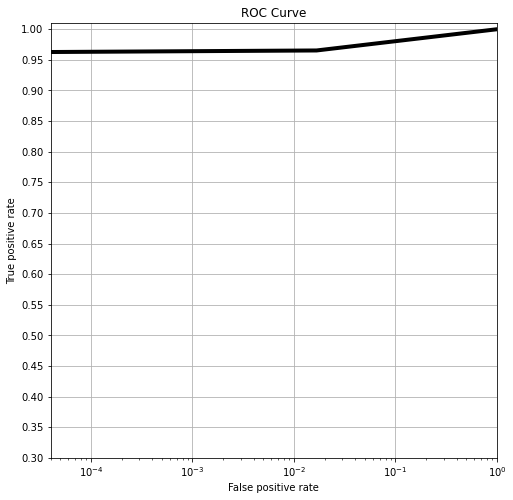

In [31]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k')
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.3, 1.01])
plt.gca().grid(True)
plt.vlines(fpr, 0, 1 - fnr, color="r", lw=2)
plt.hlines(1 - fnr, 0, fpr, color="r", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("ROC Curve")

Text(0.9999999999999062, 10, 'Threshold = 1.000\nFPR = 0.000')

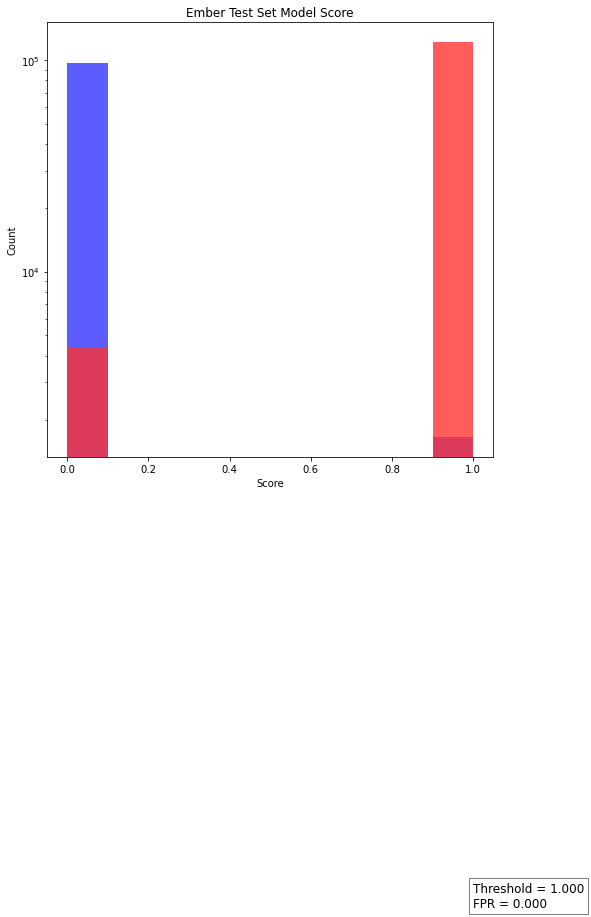

In [32]:
fig = plt.figure(figsize=(8, 8))
testdf[testdf["label"] == 0].y_pred.hist(range=[0, 1], bins=10, color="#3333ff", alpha=0.8, label="benign")
testdf[testdf["label"] == 1].y_pred.hist(range=[0, 1], bins=10, color="#ff3333", alpha=0.8, label="malicious")
plt.gca().set_yscale("log", nonpositive="clip")
plt.gca().grid(False)
plt.xlabel("Score")
plt.ylabel("Count")
_ = plt.title("Ember Test Set Model Score")

plt.text(threshold, 10, f'Threshold = {threshold:.3f}\nFPR = {fpr:.3f}', color='black', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))